# EE 379K Final Project
Rahul Jain, Keyur Muzumdar, Aditya Kharosekar

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random

from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import xgboost
from sklearn.decomposition import PCA

In [35]:
df = pd.read_csv('NFLPlaybyPlay2015.csv')

C:\Users\Aditya Kharosekar\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [36]:
df.shape

(46129, 66)

In the PlayType column, there are some instances of KickOffs, Two Minute warning, and other plays which are not relevant to us. I will only keep the plays which we will need.

In [37]:
df['PlayType'].replace(
    to_replace = 'Sack',
    value='Pass',
    inplace=True
)
relevantPlays = ['Run', 'Pass', 'Punt', 'Field Goal', 'QB Kneel','Kickoff', 'Onside Kick']
df = df.loc[df['PlayType'].isin(relevantPlays)]

In [38]:
df.shape

(39111, 66)

In [39]:
df = df.dropna(subset = ['posteam'])
df.shape

(39090, 66)

In [40]:
pass_tendencies = {}

#Source: https://www.teamrankings.com/nfl/stat/passing-play-pct?date=2016-02-08
pass_tendencies['ARI'] = 58.16
pass_tendencies['ATL'] = 60.8
pass_tendencies['BAL'] = 64.64
pass_tendencies['BUF'] = 49.90
pass_tendencies['CAR'] = 50.16
pass_tendencies['CHI'] = 54.30
pass_tendencies['CIN'] = 54.2
pass_tendencies['CLE'] = 63.53
pass_tendencies['DAL'] = 57.94
pass_tendencies['DEN'] = 59.78
pass_tendencies['DET'] = 65.63
pass_tendencies['GB'] = 58.89
pass_tendencies['HOU'] = 58.20
pass_tendencies['IND'] = 62.36
pass_tendencies['JAC'] = 65.02
pass_tendencies['KC'] = 54.09
pass_tendencies['MIA'] = 64.79
pass_tendencies['MIN'] = 51.12
pass_tendencies['NE'] = 65.00
pass_tendencies['NO'] = 63.78
pass_tendencies['NYG'] = 61.73
pass_tendencies['NYJ'] = 58.29
pass_tendencies['OAK'] = 63.33
pass_tendencies['PHI'] = 59.84
pass_tendencies['PIT'] = 61.72
pass_tendencies['SD'] = 64.27
pass_tendencies['SEA'] = 53.29
pass_tendencies['SF'] = 59.75
pass_tendencies['STL'] = 53.37
pass_tendencies['TB'] = 55.32
pass_tendencies['TEN'] = 61.99
pass_tendencies['WAS'] = 58.65

In [41]:
posteam = df['posteam']
pass_ratio = []
for team in posteam:
    pass_ratio.append(pass_tendencies[team])

df['PassRatio'] = pass_ratio

In [42]:
df = df.loc[:, 'Date':]
df.head()

,Date,GameID,Drive,qtr,down,time,TimeUnder,TimeSecs,PlayTimeDiff,SideofField,...,PenalizedTeam,PenaltyType,PenalizedPlayer,Penalty.Yards,PosTeamScore,DefTeamScore,ScoreDiff,AbsScoreDiff,Season,PassRatio
0,2015-09-10,2015091000,1,1,NaN,15:00,15,3600.0,0.0,NE,...,NaN,NaN,NaN,0,0.0,0.0,0.0,0.0,2015,61.72
1,2015-09-10,2015091000,1,1,1.0,15:00,15,3600.0,0.0,PIT,...,NaN,NaN,NaN,0,0.0,0.0,0.0,0.0,2015,61.72
2,2015-09-10,2015091000,1,1,1.0,14:21,15,3561.0,39.0,PIT,...,NaN,NaN,NaN,0,0.0,0.0,0.0,0.0,2015,61.72
3,2015-09-10,2015091000,1,1,2.0,14:04,15,3544.0,17.0,PIT,...,NaN,NaN,NaN,0,0.0,0.0,0.0,0.0,2015,61.72
4,2015-09-10,2015091000,1,1,1.0,13:26,14,3506.0,38.0,NE,...,NaN,NaN,NaN,0,0.0,0.0,0.0,0.0,2015,61.72


In [43]:
plays = df['PlayType']
isKick = []
for play in plays:
    if play=='Kickoff' or play=='Onside Kick':
        isKick = 1
    else:
        isKick = 0
df['isKick'] = isKick

In [44]:
for play in relevantPlays:
    df2 = df.loc[df['PlayType']==play]
    print("Number of ", play, " plays :", df2.shape[0])

Number of  Run  plays : 13088
Number of  Pass  plays : 19514
Number of  Punt  plays : 2443
Number of  Field Goal  plays : 988
Number of  QB Kneel  plays : 425
Number of  Kickoff  plays : 2565
Number of  Onside Kick  plays : 67


In [45]:
X = df.drop('PlayType', 1)
y = df['PlayType']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.35)

## A very, very naive baseline model
Idea: Find the counts of each play in the train set. Predict each play in the test set based on the proportion of each play in the training set.
Important assumption - Our train and test sets have roughly the same probability of each play. if we don't improve on this stupid-ass model(which doesn't even use X_train and X_test) we should just drop out. But at the same time, a good reference point

In [46]:
for play in relevantPlays:
    df2 = y_train.loc[y_train==play]
    print("Number of ", play, " plays :", df2.shape[0])

Number of  Run  plays : 8446
Number of  Pass  plays : 12749
Number of  Punt  plays : 1574
Number of  Field Goal  plays : 648
Number of  QB Kneel  plays : 271
Number of  Kickoff  plays : 1676
Number of  Onside Kick  plays : 44


In [47]:
probs = []
for play in relevantPlays:
    df2 = y_train.loc[y_train==play]
    probs.append(df2.shape[0] / y_train.shape[0])

In [48]:
probs

[0.33241498740554154,
 0.5017710957178841,
 0.061948992443324934,
 0.025503778337531487,
 0.010665931989924434,
 0.06596347607052896,
 0.0017317380352644836]

In [49]:
cumulative_probs = []
running_sum = 0.0
for i in range(0, len(relevantPlays)):
    running_sum = running_sum + probs[i]
    cumulative_probs.append(running_sum)

In [50]:
cumulative_probs

[0.33241498740554154,
 0.8341860831234257,
 0.8961350755667506,
 0.9216388539042821,
 0.9323047858942065,
 0.9982682619647355,
 1.0]

In [51]:
test= []
#print (df.PlayType)
for i, row in df.iterrows():
    s = np.random.uniform(0,1,1)
    if(s< cumulative_probs[0]):
        test.append("Run")
    elif(s< cumulative_probs[1]):
        test.append("Pass")
    elif(s<cumulative_probs[2]): 
        test.append("Punt")
    elif(s <cumulative_probs[3]):
        test.append("Field Goal")
    elif(s <cumulative_probs[4]):
        test.append("QB Kneel")
    elif(s <cumulative_probs[5]):
        test.append("Spike")
    elif(s <1):
        test.append("Onside Kick")

In [52]:
df.shape

(39090, 67)

In [53]:
correct = 0
index2 = 0
for index, row in df.iterrows(): 
    #print(index, df.PlayType[index])
    if(df.PlayType[index] == test[index2]):
        correct += 1
    index2 += 1
print(correct/ len(test))

0.36525965720133025


This probabilistic baseline model correctly predicts the type of play around 36% of the time.

Another baseline model, which always predicts a pass play, will be correct about 51.8% of the time.

### Some feature engineering

First, I will create a column that tells us whether a team is in or near field goal range.
It will have the following values - 1 if team in possession is in field goal range(within opposition's 38 yard line), 2 if team is close to field goal range(within 5 yards of getting into field goal range), 3 if team is further back.

In [54]:
fieldPosition = df['yrdline100']
field_goal_range = []
for yards in fieldPosition:
    if yards > 42:
        field_goal_range.append(3)
    elif yards <= 42 and yards > 37:
        field_goal_range.append(2)
    else:
        field_goal_range.append(1)

df['FieldGoalRange'] = field_goal_range

Now I will create a categorical feature describing the distance to the first down marker for each play.
This feature, DistanceToFirst, will take on one of the following values - 
If short (<4 yards till first down marker) - 1,
If medium (4-7 yards till first down marker) - 2,
If long(8+ yards) - 3

In [55]:
yardstogo = df['ydstogo']
plays = []
for yards in yardstogo:
    if yards >=8: #long yardage situation
        plays.append(3)
    elif yards >=4 and yards <=7: #medium yardage
        plays.append(2)
    else: #short yardage
        plays.append(1)
        
df['DistanceToFirst'] = plays

In [56]:
lastplay = []
indices = []
lastPlayScore = [] 
i = 0
for index, range in df.iterrows(): 
    x = "N/A"
    score = 0
    indices.sort(reverse=True)
    for ind in indices: 
        if df.posteam[ind] == df.posteam[index] and df.GameID[ind] == df.GameID[index]:
            x = (df.PlayType[ind])
            break
    if(x == "N/A"):
        s = np.random.uniform(0,1,1)
        if(s<df.PassRatio[index]):
            x= "Pass"
        else:
            x = "Run"
    if(len(indices) > 0 ): 
        if(df.Touchdown[indices[0]] == 1 or df.FieldGoalResult[indices[0]] == 'Good'):
            score = 1 
    lastPlayScore.append(score)
    indices.append(index)
    lastplay.append(x)

In [57]:
df["LastPlay"] = lastplay
df["LastPlayScore"] = lastPlayScore
df.head()

,Date,GameID,Drive,qtr,down,time,TimeUnder,TimeSecs,PlayTimeDiff,SideofField,...,DefTeamScore,ScoreDiff,AbsScoreDiff,Season,PassRatio,isKick,FieldGoalRange,DistanceToFirst,LastPlay,LastPlayScore
0,2015-09-10,2015091000,1,1,NaN,15:00,15,3600.0,0.0,NE,...,0.0,0.0,0.0,2015,61.72,0,1,1,Pass,0
1,2015-09-10,2015091000,1,1,1.0,15:00,15,3600.0,0.0,PIT,...,0.0,0.0,0.0,2015,61.72,0,3,3,Kickoff,0
2,2015-09-10,2015091000,1,1,1.0,14:21,15,3561.0,39.0,PIT,...,0.0,0.0,0.0,2015,61.72,0,3,3,Run,0
3,2015-09-10,2015091000,1,1,2.0,14:04,15,3544.0,17.0,PIT,...,0.0,0.0,0.0,2015,61.72,0,3,1,Pass,0
4,2015-09-10,2015091000,1,1,1.0,13:26,14,3506.0,38.0,NE,...,0.0,0.0,0.0,2015,61.72,0,3,3,Run,0


In [ ]:
data.posteam.unique()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.18, random_state = 14)
# This will give you the pass ratio of the train set. the train set and test set should be passed in WITH
#the RushAttempt and PAssAttempt columns still in the data. None of the columns should be turned from strings to dummies. 
#the function will output test and train ready to perform calculations on. 
def fill_percents(train, test): 
    teams = ['PIT', 'NE', 'CHI', 'GB', 'KC', 'HOU', 'NYJ', 'CLE', 'IND', 'BUF',
       'WAS', 'MIA', 'JAC', 'CAR', 'SEA', 'STL', 'ARI', 'NO', 'DET', 'SD',
       'TEN', 'TB', 'OAK', 'CIN', 'BAL', 'DEN', 'DAL', 'NYG', 'PHI', 'ATL',
       'SF', 'MIN']
    d = {}
    for team in teams:
        d[team] = [0,0] 
    for i, range in train.iterrows(): 
        if(train.PassAttempt[i] == 1):
            d[data.posteam[i]] = [d[data.posteam[i]][0] + 1,d[data.posteam[i]][1]]  
        elif(data.RushAttempt[i] == 1):
            d[data.posteam[i]] = [d[data.posteam[i]][0],d[data.posteam[i]][1]+1]
    percent = []
    for i, range in train.iterrows():
        x = float(d[train.posteam[i]][0])/ (d[train.posteam[i]][0] + d[train.posteam[i]][1])
        percent.append(x)
    train["PassRatio2"] = percent
    percent = []
    for i, range in test.iterrows():
        x = float(d[test.posteam[i]][0])/ (d[test.posteam[i]][0] + d[test.posteam[i]][1])
        percent.append(x)
    test["PassRatio2"] = percent
    dum1 = pd.get_dummies(train[['LastPlay', 'SideofField', 'posteam', 'DefensiveTeam']])
    train = train.drop(['LastPlay', 'SideofField', 'posteam', 'DefensiveTeam'], axis=1)
    train = pd.concat([train, dum1], axis = 1)
    dum1 = pd.get_dummies(test[['LastPlay', 'SideofField', 'posteam', 'DefensiveTeam']])
    test = test.drop(['LastPlay', 'SideofField', 'posteam', 'DefensiveTeam'], axis=1)
    test = pd.concat([test, dum1], axis = 1)
    test = test.drop(['RushAttempt', 'PassAttempt','Drive'], axis=1)
    train = train.drop(['RushAttempt', 'PassAttempt','Drive'], axis=1)
    return train, test

### Regression Models

Going to start by making a new dataframe with the relevant predictors. Quite a few describe the play outcome which we can't use, and others, such as passer, have an NaN if it's not a pass play. We'd import the team QB ourselves in this case.

In [58]:
df.columns

Index(['Date', 'GameID', 'Drive', 'qtr', 'down', 'time', 'TimeUnder',
       'TimeSecs', 'PlayTimeDiff', 'SideofField', 'yrdln', 'yrdline100',
       'ydstogo', 'ydsnet', 'GoalToGo', 'FirstDown', 'posteam',
       'DefensiveTeam', 'desc', 'PlayAttempted', 'Yards.Gained', 'sp',
       'Touchdown', 'ExPointResult', 'TwoPointConv', 'DefTwoPoint', 'Safety',
       'PuntResult', 'PlayType', 'Passer', 'PassAttempt', 'PassOutcome',
       'PassLength', 'PassLocation', 'InterceptionThrown', 'Interceptor',
       'Rusher', 'RushAttempt', 'RunLocation', 'RunGap', 'Receiver',
       'Reception', 'ReturnResult', 'Returner', 'BlockingPlayer', 'Tackler1',
       'Tackler2', 'FieldGoalResult', 'FieldGoalDistance', 'Fumble',
       'RecFumbTeam', 'RecFumbPlayer', 'Sack', 'Challenge.Replay',
       'ChalReplayResult', 'Accepted.Penalty', 'PenalizedTeam', 'PenaltyType',
       'PenalizedPlayer', 'Penalty.Yards', 'PosTeamScore', 'DefTeamScore',
       'ScoreDiff', 'AbsScoreDiff', 'Season', 'PassRatio', '

In [59]:
df_rel = df[[
    'Drive',
    'qtr',
    'down',
    'time',
    'LastPlay',
    'LastPlayScore',
    'TimeSecs',
    'SideofField',
    'yrdln',
    'yrdline100',
    'ydstogo',
    'GoalToGo',
    'posteam',
    'DefensiveTeam',
    'PlayType', # predicting on
    'PosTeamScore',
    'DefTeamScore',
    'ScoreDiff',
#     'AbsScoreDiff',
    'PassRatio',
    'FieldGoalRange',
    'DistanceToFirst'
    ]]


In [60]:
df_rel.tail()

,Drive,qtr,down,time,LastPlay,LastPlayScore,TimeSecs,SideofField,yrdln,yrdline100,...,GoalToGo,posteam,DefensiveTeam,PlayType,PosTeamScore,DefTeamScore,ScoreDiff,PassRatio,FieldGoalRange,DistanceToFirst
46124,22,4,4.0,00:43,Pass,0,43.0,GB,42.0,58.0,...,0.0,GB,MIN,Pass,13.0,19.0,-6.0,58.89,3,3
46125,22,4,1.0,00:27,Pass,0,27.0,MIN,46.0,46.0,...,0.0,GB,MIN,Pass,13.0,19.0,-6.0,58.89,3,3
46126,22,4,2.0,00:24,Pass,0,24.0,MIN,39.0,39.0,...,0.0,GB,MIN,Pass,13.0,19.0,-6.0,58.89,2,1
46127,22,4,3.0,00:15,Pass,0,15.0,MIN,39.0,39.0,...,0.0,GB,MIN,Pass,13.0,19.0,-6.0,58.89,2,1
46128,22,4,4.0,00:01,Pass,0,1.0,MIN,38.0,38.0,...,0.0,GB,MIN,Pass,13.0,19.0,-6.0,58.89,2,1


Seems 'sideOfFIeld' 'yrdln' == 'yrdline100' as long as sideOfField matches; makes sense to encode sideOfField and make an interaction with yrdln. Furthermore, an interaction with the encoded possession team with side of field should create understanding of how which side you're on matters.

**Encode**

In [61]:
dm = pd.get_dummies(df_rel[['posteam', 'DefensiveTeam', 'SideofField']])
df_rel = df_rel.drop(['posteam', 'DefensiveTeam', 'SideofField'], axis=1)
df_rel = pd.concat([df_rel, dm], axis=1)

In [62]:
df_rel.head()

,Drive,qtr,down,time,LastPlay,LastPlayScore,TimeSecs,yrdln,yrdline100,ydstogo,...,SideofField_OAK,SideofField_PHI,SideofField_PIT,SideofField_SD,SideofField_SEA,SideofField_SF,SideofField_STL,SideofField_TB,SideofField_TEN,SideofField_WAS
0,1,1,NaN,15:00,Pass,0,3600.0,35.0,35.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,1.0,15:00,Kickoff,0,3600.0,20.0,80.0,10,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,1,1.0,14:21,Run,0,3561.0,38.0,62.0,10,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,1,2.0,14:04,Pass,0,3544.0,47.0,53.0,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,1,1.0,13:26,Run,0,3506.0,49.0,49.0,10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Interactions**

In [63]:
# posteam and SideofFIeld
df_pos = pd.get_dummies(df[['posteam', 'SideofField']])
df_pos = PolynomialFeatures(2, interaction_only=False, include_bias=False).fit_transform(df_pos)

# DefensiveTeam and SideofField
df_def = pd.get_dummies(df[['DefensiveTeam', 'SideofField']])
df_def = PolynomialFeatures(2, interaction_only=False, include_bias=False).fit_transform(df_def)


# df_int = df_rel[['sideOfField', 'yrdln', 'yrdline100']]
# pf = PolynomialFeatures(2, interaction_only=True, include_bias=False).fit_transform(df_int)

*Actually it'd be so sparse we're likely better off just iterating through and making one column such that*

    if posteam == SideofField: posTeamSideofField = 1 else 0
    
The encoding is still necessary though for posteam, DefensiveTeam

In [64]:
posTeamSoF = []
inds = []
for index, row in df.iterrows(): # iterates in order, verified
    inds.append(index)
    if(row.ix['posteam'] == row.ix['SideofField']):
        posTeamSoF.append(1)
    else:
        posTeamSoF.append(-1)

In [65]:
posTeamSoF = pd.DataFrame( posTeamSoF, index = inds)
posTeamSoF.rename(index = str, columns = {0: 'posTeamSoF'}, inplace=True)
posTeamSoF.head()

,posTeamSoF
0,-1
1,1
2,1
3,1
4,-1


In [80]:
df_rel = df[[
    'Drive',
    'qtr',
    'down',
    'time',
    'LastPlay',
    'LastPlayScore',
    'TimeSecs',
    'SideofField',
    'yrdln',
    'yrdline100',
    'ydstogo',
    'GoalToGo',
    'posteam',
    'isKick',
    'DefensiveTeam',
    'PlayType', # predicting on
    'PosTeamScore',
    'DefTeamScore',
    'ScoreDiff',
#     'AbsScoreDiff',
    'PassRatio',
    'FieldGoalRange',
    'DistanceToFirst'
    ]]
df_rel['posTeamSoF'] = np.asarray(posTeamSoF)
df_rel.head()

C:\Users\Aditya Kharosekar\Anaconda3\lib\site-packages\ipykernel\__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Drive,qtr,down,time,LastPlay,LastPlayScore,TimeSecs,SideofField,yrdln,yrdline100,...,isKick,DefensiveTeam,PlayType,PosTeamScore,DefTeamScore,ScoreDiff,PassRatio,FieldGoalRange,DistanceToFirst,posTeamSoF
0,1,1,NaN,15:00,Pass,0,3600.0,NE,35.0,35.0,...,0,NE,Kickoff,0.0,0.0,0.0,61.72,1,1,-1
1,1,1,1.0,15:00,Kickoff,0,3600.0,PIT,20.0,80.0,...,0,NE,Run,0.0,0.0,0.0,61.72,3,3,1
2,1,1,1.0,14:21,Run,0,3561.0,PIT,38.0,62.0,...,0,NE,Pass,0.0,0.0,0.0,61.72,3,3,1
3,1,1,2.0,14:04,Pass,0,3544.0,PIT,47.0,53.0,...,0,NE,Run,0.0,0.0,0.0,61.72,3,1,1
4,1,1,1.0,13:26,Run,0,3506.0,NE,49.0,49.0,...,0,NE,Pass,0.0,0.0,0.0,61.72,3,3,-1


In [81]:
# now multiply ydln (0 to 50) * the {-1, 1} for which side they're on
df_rel['50yd_byteam'] = df_rel['yrdln'] * df_rel['posTeamSoF']
df_rel.head()

C:\Users\Aditya Kharosekar\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,Drive,qtr,down,time,LastPlay,LastPlayScore,TimeSecs,SideofField,yrdln,yrdline100,...,DefensiveTeam,PlayType,PosTeamScore,DefTeamScore,ScoreDiff,PassRatio,FieldGoalRange,DistanceToFirst,posTeamSoF,50yd_byteam
0,1,1,NaN,15:00,Pass,0,3600.0,NE,35.0,35.0,...,NE,Kickoff,0.0,0.0,0.0,61.72,1,1,-1,-35.0
1,1,1,1.0,15:00,Kickoff,0,3600.0,PIT,20.0,80.0,...,NE,Run,0.0,0.0,0.0,61.72,3,3,1,20.0
2,1,1,1.0,14:21,Run,0,3561.0,PIT,38.0,62.0,...,NE,Pass,0.0,0.0,0.0,61.72,3,3,1,38.0
3,1,1,2.0,14:04,Pass,0,3544.0,PIT,47.0,53.0,...,NE,Run,0.0,0.0,0.0,61.72,3,1,1,47.0
4,1,1,1.0,13:26,Run,0,3506.0,NE,49.0,49.0,...,NE,Pass,0.0,0.0,0.0,61.72,3,3,-1,-49.0


In [82]:
df_rel = df_rel.drop(['yrdln'], axis=1)

In [83]:
df_rel.head()

,Drive,qtr,down,time,LastPlay,LastPlayScore,TimeSecs,SideofField,yrdline100,ydstogo,...,DefensiveTeam,PlayType,PosTeamScore,DefTeamScore,ScoreDiff,PassRatio,FieldGoalRange,DistanceToFirst,posTeamSoF,50yd_byteam
0,1,1,NaN,15:00,Pass,0,3600.0,NE,35.0,0,...,NE,Kickoff,0.0,0.0,0.0,61.72,1,1,-1,-35.0
1,1,1,1.0,15:00,Kickoff,0,3600.0,PIT,80.0,10,...,NE,Run,0.0,0.0,0.0,61.72,3,3,1,20.0
2,1,1,1.0,14:21,Run,0,3561.0,PIT,62.0,10,...,NE,Pass,0.0,0.0,0.0,61.72,3,3,1,38.0
3,1,1,2.0,14:04,Pass,0,3544.0,PIT,53.0,1,...,NE,Run,0.0,0.0,0.0,61.72,3,1,1,47.0
4,1,1,1.0,13:26,Run,0,3506.0,NE,49.0,10,...,NE,Pass,0.0,0.0,0.0,61.72,3,3,-1,-49.0


In [84]:
# convert back to 1 and 0 binary column
df_rel['posTeamSoF'] = df_rel['posTeamSoF'] + 1
df_rel['posTeamSoF'] = df_rel['posTeamSoF'] / 2
df_rel.head()

,Drive,qtr,down,time,LastPlay,LastPlayScore,TimeSecs,SideofField,yrdline100,ydstogo,...,DefensiveTeam,PlayType,PosTeamScore,DefTeamScore,ScoreDiff,PassRatio,FieldGoalRange,DistanceToFirst,posTeamSoF,50yd_byteam
0,1,1,NaN,15:00,Pass,0,3600.0,NE,35.0,0,...,NE,Kickoff,0.0,0.0,0.0,61.72,1,1,0.0,-35.0
1,1,1,1.0,15:00,Kickoff,0,3600.0,PIT,80.0,10,...,NE,Run,0.0,0.0,0.0,61.72,3,3,1.0,20.0
2,1,1,1.0,14:21,Run,0,3561.0,PIT,62.0,10,...,NE,Pass,0.0,0.0,0.0,61.72,3,3,1.0,38.0
3,1,1,2.0,14:04,Pass,0,3544.0,PIT,53.0,1,...,NE,Run,0.0,0.0,0.0,61.72,3,1,1.0,47.0
4,1,1,1.0,13:26,Run,0,3506.0,NE,49.0,10,...,NE,Pass,0.0,0.0,0.0,61.72,3,3,0.0,-49.0


In [86]:
df_rel.to_csv('Cleanest_data_yet.csv')

### df_rel is in a decent place to start predicting

In [13]:
data = pd.read_csv('Cleanest_data_yet.csv')

In [14]:
data.shape

(39090, 24)

In [15]:
data = data.loc[:, 'Drive':]
data.head()

,Drive,qtr,down,time,LastPlay,LastPlayScore,TimeSecs,SideofField,yrdline100,ydstogo,...,DefensiveTeam,PlayType,PosTeamScore,DefTeamScore,ScoreDiff,PassRatio,FieldGoalRange,DistanceToFirst,posTeamSoF,50yd_byteam
0,1,1,NaN,15:00,Pass,0,3600.0,NE,35.0,0,...,NE,Kickoff,0.0,0.0,0.0,61.72,1,1,0.0,-35.0
1,1,1,1.0,15:00,Kickoff,0,3600.0,PIT,80.0,10,...,NE,Run,0.0,0.0,0.0,61.72,3,3,1.0,20.0
2,1,1,1.0,14:21,Run,0,3561.0,PIT,62.0,10,...,NE,Pass,0.0,0.0,0.0,61.72,3,3,1.0,38.0
3,1,1,2.0,14:04,Pass,0,3544.0,PIT,53.0,1,...,NE,Run,0.0,0.0,0.0,61.72,3,1,1.0,47.0
4,1,1,1.0,13:26,Run,0,3506.0,NE,49.0,10,...,NE,Pass,0.0,0.0,0.0,61.72,3,3,0.0,-49.0


## Ridge Regression Model

In [ ]:
num_folds = 10
SEED = 5
total = 0.0
for i in range(num_folds):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = i*SEED)
    ridge = RidgeClassifier(n_estimators = 50)
    ridge.fit(X_train, y_train)
    preds = ridge.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    
    print("Accuracy for fold ", i+1, "/", num_folds, ":", accuracy)
    total = total + accuracy

    
#     confusion = confusion_matrix(y_test, preds, labels = [1, 2, 3, 4, 5, 6, 7])
#     print(confusion)
print(num_folds, "- fold accuracy :", total / num_folds)

## KNN Model

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
num_folds = 10
SEED = 5
total = 0.0
i  = 0
while  i < num_folds:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = i*SEED)
    neigh = KNeighborsClassifier(n_neighbors=1)
    neigh.fit(X_train, y_train) 
    preds = neigh.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    print("Accuracy for fold ", i+1, "/", num_folds, ":", accuracy)
    total = total + accuracy
    i += 1
    
print(num_folds, "-fold accuracy :", total / num_folds)

## Multilayer Perceptron

In [ ]:
from sklearn.neural_network import MLPClassifier
num_folds = 10
SEED = 5
total = 0.0
i  = 0
while  i < num_folds:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = i*SEED)
    mlp = MLPClassifier()
    mlp.fit(X_train, y_train) 
    preds = mlp.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    print("Accuracy for fold ", i+1, "/", num_folds, ":", accuracy)
    total = total + accuracy
    i += 1
    
print(num_folds, "-fold accuracy :", total / num_folds)

## Random Forest

In [16]:
X = data.drop(['PlayType', 'time'], axis = 1)
y = data['PlayType']

In [17]:
dum1 = pd.get_dummies(X[['LastPlay', 'SideofField', 'posteam', 'DefensiveTeam']])
X = X.drop(['LastPlay', 'SideofField', 'posteam', 'DefensiveTeam'], axis=1)
X = pd.concat([X, dum1], axis = 1)

In [18]:
y = y.replace(to_replace = ['Run', 'Pass', 'Punt', 'Field Goal', 'QB Kneel', 'Kickoff', 'Onside Kick'],
         value = [1, 2, 3, 4, 5, 6, 7])

In [19]:
X['down'].fillna(round(X.down.mean()), inplace = True)

In [ ]:
num_folds = 10
SEED = 5
total = 0.0
for i in range(num_folds):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = i*SEED)
    rf = RandomForestClassifier(n_estimators = 50)
    rf.fit(X_train, y_train)
    preds = rf.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    
    print("Accuracy for fold ", i+1, "/", num_folds, ":", accuracy)
    total = total + accuracy

    
#     confusion = confusion_matrix(y_test, preds, labels = [1, 2, 3, 4, 5, 6, 7])
#     print(confusion)
print(num_folds, "- fold accuracy :", total / num_folds)

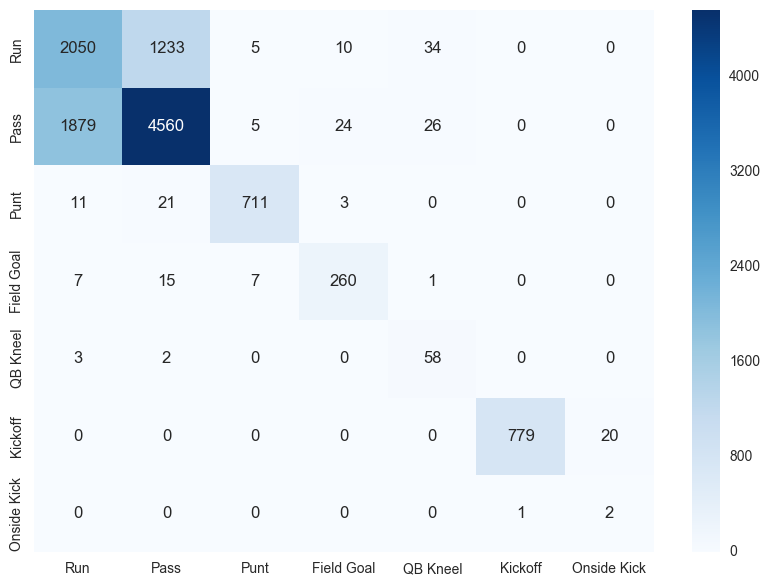

In [25]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = cm.astype(int)
pla = ["Run", "Pass", "Punt","Field Goal", "QB Kneel", "Kickoff", "Onside Kick"]
df_cm = pd.DataFrame(array, index = [i for i in pla],
                  columns = [i for i in pla])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')

C:\Users\Aditya Kharosekar\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


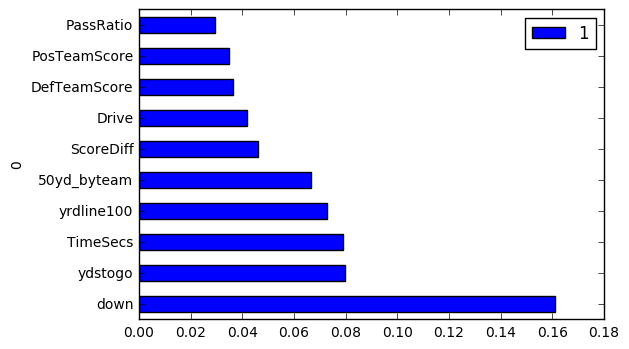

In [10]:
ft_imp = []
for index, value in enumerate(rf.feature_importances_):
    ft_imp.append([X.columns[index], value])

num_features = 10
ft_imp = pd.DataFrame(ft_imp)
ft_imp.sort(columns = 1, inplace = True, ascending = False)
ft_imp.head(num_features).plot(x=ft_imp.head(num_features)[0], kind='barh')

## XGBoost Model

In [ ]:
num_folds = 10
SEED = 5
total = 0.0
for i in range(num_folds):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = i*SEED)
    xgb = xgboost.XGBClassifier(n_estimators = 50)
    xgb.fit(X_train, y_train)
    preds = xgb.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    
    print("Accuracy for fold ", i+1, "/", num_folds, ":", accuracy)
    total = total + accuracy

    
#     confusion = confusion_matrix(y_test, preds, labels = [1, 2, 3, 4, 5, 6, 7])
#     print(confusion)
print(num_folds, "- fold accuracy :", total / num_folds)

In [ ]:
ft_imp = []
for index, value in enumerate(xgb.feature_importances_):
    ft_imp.append([X.columns[index], value])

num_features = 10
ft_imp = pd.DataFrame(ft_imp)
ft_imp.sort(columns = 1, inplace = True, ascending = False)
ft_imp.head(num_features).plot(x=ft_imp.head(num_features)[0], kind='barh')

## Computing correlation between different models to pick models to stack

In [15]:
from scipy.stats import linregress
X_train, X_test, y_train, y_test = train_test_split(X, y)
rf = RandomForestClassifier(n_estimators = 50)
rf.fit(X_train, y_train)
rfpreds = rf.predict(X_test)

xgb = xgboost.XGBClassifier()
xgb.fit(X_train, y_train)
xgpreds = xgb.predict(X_test)

linregress(rfpreds, xgpreds)

LinregressResult(slope=0.94099611267244976, intercept=0.13995189004677178, rvalue=0.92126989355443012, pvalue=0.0, stderr=0.0040187968365452088)

The Random Forest and XGBoost models are very correlated (The correlation coefficient is 0.92). No point trying to ensemble them

In [17]:
from scipy.stats import linregress
X_train, X_test, y_train, y_test = train_test_split(X, y)
rf = RandomForestClassifier(n_estimators = 50)
rf.fit(X_train, y_train)
rfpreds = rf.predict(X_test)

ridge = RidgeClassifier()
ridge.fit(X_train, y_train)
ridgepreds = ridge.predict(X_test)

linregress(rfpreds, ridgepreds)

LinregressResult(slope=0.65008968465472594, intercept=0.67471547475791094, rvalue=0.73804301402285155, pvalue=0.0, stderr=0.0060126697023211509)

Correlation coefficient between the Random Forest and the Ridge Regression model = 0.74

In [18]:
from scipy.stats import linregress
X_train, X_test, y_train, y_test = train_test_split(X, y)
ridge = RidgeClassifier()
ridge.fit(X_train, y_train)
ridgepreds = ridge.predict(X_test)

xgb = xgboost.XGBClassifier()
xgb.fit(X_train, y_train)
xgpreds = xgb.predict(X_test)

linregress(ridgepreds, xgpreds)

LinregressResult(slope=0.85913676264577177, intercept=0.36454075948176445, rvalue=0.73585812373850756, pvalue=0.0, stderr=0.007997872011335538)

## Trying to stack the Ridge Regression Model and the XGBoost model

In [11]:
finalpreds = (1*xgpreds + 0.0*ridgepreds)
finalpreds = [round(pred) for pred in finalpreds]
accuracy_score(y_test, finalpreds)

NameError: name 'xgpreds' is not defined

## Trying PCA on Random Forest

In [9]:
num_folds = 10
SEED = 5
total = 0.0
pca = PCA(n_components = 100)
X = pca.fit_transform(X)
for i in range(num_folds):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = i*SEED)
    rf = RandomForestClassifier(n_estimators = 50)
    rf.fit(X_train, y_train)
    preds = rf.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    
    print("Accuracy for fold ", i+1, "/", num_folds, ":", accuracy)
    total = total + accuracy

    
#     confusion = confusion_matrix(y_test, preds, labels = [1, 2, 3, 4, 5, 6, 7])
#     print(confusion)
print(num_folds, "- fold accuracy :", total / num_folds)

Accuracy for fold  1 / 10 : 0.68713225889
Accuracy for fold  2 / 10 : 0.690713737529
Accuracy for fold  3 / 10 : 0.689349364714
Accuracy for fold  4 / 10 : 0.690202097723
Accuracy for fold  5 / 10 : 0.689264091413
Accuracy for fold  6 / 10 : 0.691822290441
Accuracy for fold  7 / 10 : 0.693271936557
Accuracy for fold  8 / 10 : 0.688496631705
Accuracy for fold  9 / 10 : 0.688837724908
Accuracy for fold  10 / 10 : 0.697023961798
10 - fold accuracy : 0.690611409568


** Doing PCA with 50 dimensions got average accuracy of 0.705 **

** Doing PCA with 100 dimensions got average accuracy of 0.69 **

## Trying PCA on XGBoost models

In [11]:
num_folds = 10
SEED = 5
total = 0.0
pca = PCA(n_components = 50)
X = pca.fit_transform(X)
for i in range(num_folds):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = i*SEED)
    xg = xgboost.XGBClassifier()
    xg.fit(X_train, y_train)
    preds = xg.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    
    print("Accuracy for fold ", i+1, "/", num_folds, ":", accuracy)
    total = total + accuracy

    
#     confusion = confusion_matrix(y_test, preds, labels = [1, 2, 3, 4, 5, 6, 7])
#     print(confusion)
print(num_folds, "- fold accuracy :", total / num_folds)

Accuracy for fold  1 / 10 : 0.71655154771
Accuracy for fold  2 / 10 : 0.721838492368
Accuracy for fold  3 / 10 : 0.723117591882
Accuracy for fold  4 / 10 : 0.722605952076
Accuracy for fold  5 / 10 : 0.72388505159
Accuracy for fold  6 / 10 : 0.717915920525
Accuracy for fold  7 / 10 : 0.72755180353
Accuracy for fold  8 / 10 : 0.721923765669
Accuracy for fold  9 / 10 : 0.719962479748
Accuracy for fold  10 / 10 : 0.723629231688
10 - fold accuracy : 0.721898183679


** PCA on XGBoost model with 100 dimensions has accuracy of 0.723 **

** PCA on XGBoost model with 50 dimensions - 0.722 **